In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131322 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
#Check the dataset sizes(in MB)
!du -l drive/toxic_comment/input/*

58941	drive/toxic_comment/input/test.csv
4861	drive/toxic_comment/input/test_labels.csv
67191	drive/toxic_comment/input/train.csv


In [0]:
!pip install wordcloud

In [0]:
!pip install nltk

In [0]:
!conda install -c anaconda nltk

/bin/bash: conda: command not found


In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split





#settings
start_time=time.time()

color = sns.color_palette()
sns.set_style("dark")

eng_stopwords = set(stopwords.words("english")) #stopwords
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()  #stem
tokenizer=TweetTokenizer() #tokenizer

%matplotlib inline

##Data Exploration

In [0]:
#importing the dataset
train=pd.read_csv("drive/toxic_comment/input/train.csv")
test=pd.read_csv("drive/toxic_comment/input/test.csv")

In [0]:
print(train.tail(10))
print(train.info())

                      id                                       comment_text  \
159561  ffd2e85b07b3c7e4  "\nNo he did not, read it again (I would have ...   
159562  ffd72e9766c09c97  "\n Auto guides and the motoring press are not...   
159563  ffe029a7c79dc7fe  "\nplease identify what part of BLP applies be...   
159564  ffe897e7f7182c90  Catalan independentism is the social movement ...   
159565  ffe8b9316245be30  The numbers in parentheses are the additional ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
159561      0             0        0       0       0        

In [0]:
print(train[train['toxic']==1].shape)
print(train.toxic.value_counts())
print(train.severe_toxic.value_counts())
print(train.obscene.value_counts())
print(train.threat.value_counts())
print(train.insult.value_counts())
print(train.identity_hate.value_counts())

(15294, 8)
0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


In [0]:
#calculate the ratio of training set and test
nrow_train=train.shape[0]  #rows
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("ratio  :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
ratio  : 51    : 49


There is a 30:70 train: test split and the test set might change in the future too.

### Class Imbalance:

In [0]:
#caculate the ratio of clean comments
x=train.iloc[:,2:].sum()  #make a statics of each tag of comments
print(x)
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)  #add the value from the 3st to the end columns 
train['clean']=(rowsums==0)
#count number of clean entries
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [0]:
#check the missing values in training set and test set
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'clean'],
      dtype='object')
[ 15294.   1595.   8449.    478.   7877.   1405. 143346.]


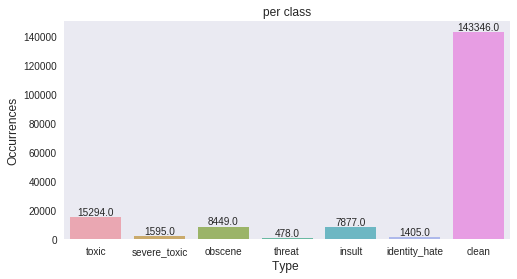

In [0]:
x=train.iloc[:,2:].sum()
print(x.index)
print(x.values)
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("per class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')  #rect.get_x() + rect.get_width()/2: write at the central

plt.show()

* The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
* There are ~95k comments in the training dataset and there are ~35 k tags and ~86k clean comments!?
    * This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene. 

### Multi-tagging:


0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64


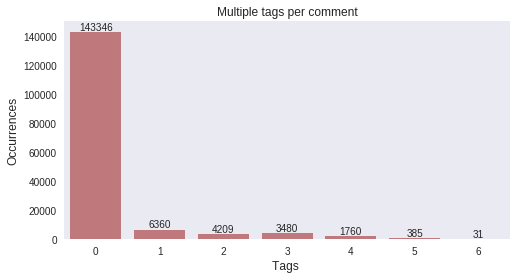

In [0]:
x=rowsums.value_counts()
print(x)

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Only ~10%(不止吧) of the total comments have some sort of toxicity in them. There are certain comments(31) that are marked as all of the above!